In [789]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler

In [821]:
tickers = ['AAPL','MSFT','CSCO','IBM','XOM']
start = '2003-01-01'
end = '2017-01-01'

def prices(tickers,start,end,backend='google'):
    if backend == 'quantopian':
        p = get_pricing(tickers,start,end)
        field = 'price'

    elif backend == 'google':
        p = web.DataReader(tickers, 'google', parse(start), parse(end)).ffill()
        field = 'Close'
        
    scaled = MinMaxScaler((0,1)).fit_transform(p[field])
    pp=pd.DataFrame(scaled,index=p[field].index,columns = tickers)
    return pp

p = prices(tickers,start,end)

In [822]:
def calc_signals(tickers,p,a,b):
    sma = p.rolling(a).mean()
    smb = p.rolling(b).mean()
    signal = np.sign(sma - smb).diff()
    actual_signals = signal[signal!=0].dropna(how='all',axis=0)
    for col in actual_signals.columns:
        idx = actual_signals[col].first_valid_index()
        signal[col][idx] = signal[col][idx]/2

    return signal

sig = calc_signals(tickers,p,40,50)



In [823]:
def calc_pnl(sig,p):
    sig_up = sig.cumsum().apply(lambda x:x*(x>0))
    sig_dwn = sig.cumsum().apply(lambda x:x*(x<0))
    pnl = cumsum(p.pct_change()*sig_up-p.pct_change()*sig_dwn).sum(axis=1)
    return pnl

def calc_sharpe(sig,p):
    pnl = calc_pnl(sig,p)
    rets = diff(pnl)/pnl[:-1]
    rets = rets[~isinf(rets)]
    sharpe = np.nanmean(rets)/np.nanstd(rets)*sqrt(252)
    return sharpe
            
#print calc_pnl(sig,p)[-1]
#print calc_sharpe(sig,p)
#plot(calc_pnl(sig,p))
#show()

In [824]:
# parameter sweep
def parameter_sweep(tickers,p,params,N):
    pnls = []
    for i in range(N):
        a = min(params[i])
        b = max(params[i])
        try:
            sig = calc_signals(tickers,p,a,b)
            pnls.append(calc_pnl(sig,p)[-1])
            #pnls.append(calc_sharpe(sig,p))
        except:
            pnls.append(np.nan)
    return pnls


In [825]:
# parameter sweep
def parameter_sweep2(tickers,p,params,N):
    pnls = []
    for i in range(N):
        a = min(params[i])
        b = max(params[i])
        try:
            sig = calc_signals(tickers,p,a,b)
            pnls.append(calc_pnl(sig,p))
        except:
            pnls.append(np.nan)
    return pnls

In [826]:

# THIS IS WITH NORMAL TRAIN/TEST PERIOD
"""N = 1000
sm = 15
lm = 95
mid_point = '2011-01-01'
params = np.array([np.random.randint(60,90,(N,)) for i in range(2)]).T
p = prices(tickers,start,mid_point)
pnls1 = parameter_sweep(tickers,p,params,N)
p = prices(tickers,mid_point,end)
pnls2 = parameter_sweep(tickers,p,vals,N)"""


"N = 1000\nsm = 15\nlm = 95\nmid_point = '2011-01-01'\nparams = np.array([np.random.randint(60,90,(N,)) for i in range(2)]).T\np = prices(tickers,start,mid_point)\npnls1 = parameter_sweep(tickers,p,params,N)\np = prices(tickers,mid_point,end)\npnls2 = parameter_sweep(tickers,p,vals,N)"

In [827]:
# THIS IS WITH VARIABLE TEST PERIOD
N = 5000
sm = 15
lm = 195
params = np.array([np.random.randint(60,90,(N,)) for i in range(2)]).T
p = prices(tickers,start,end)
pnls = parameter_sweep2(tickers,p,params,N)
pnls1 = []
pnls2 = []

frac = 5
for pnl in pnls:
    assert(frac>1)
    try:
        a0 = random.randint(0,len(pnl)-round(len(pnl)/frac))
        a1 = int(a0 + round((len(pnl)/frac)))
        pnls1.append(pnl.ix[a0]+pnl.ix[-1])
        pnls2.append(pnl.ix[a1]-pnl.ix[a0])
    except:
        pnls1.append(0)
        pnls2.append(0)


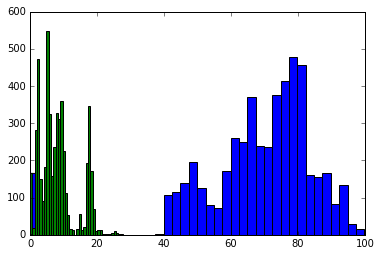

In [828]:

plt.hist(pnls1,40)
plt.hist(pnls2,40)
show()

In [829]:
def remove_nans(pnls1,pnls2,vals):
    idx1 = ~np.isnan(pnls1)
    pnls1 = np.array(pnls1)[idx1]
    pnls2 = np.array(pnls2)[idx1]
    vals = np.array(vals)[idx1]
    idx2 = ~np.isnan(pnls2)
    pnls1 = np.array(pnls1)[idx2]
    pnls2 = np.array(pnls2)[idx2]
    vals = np.array(vals)[idx2]
    return pnls1,pnls2,vals

In [830]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import calinski_harabaz_score



def get_cluster_number(X):
    score = 0 
    best_cluster_number = 0 
    for i in range(2,10):
        kmeans = AgglomerativeClustering(n_clusters = i)
        kmeans.fit(X)
        chs = calinski_harabaz_score(X,kmeans.labels_)
        if chs>score:
            best_cluster_number = i 
            score = chs 
    return best_cluster_number

pnls1,pnls2,params = remove_nans(pnls1,pnls2,params)
Nc = get_cluster_number(np.array([pnls1,pnls2]).T)
kmeans = KMeans(n_clusters=Nc).fit(np.array([pnls1,pnls2]).T)

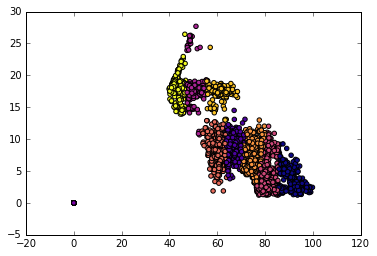

In [831]:
plt.scatter(pnls1,pnls2,c=kmeans.labels_,cmap='plasma')
show()

In [832]:
# Which cluster has the highest OOS pnl?

def find_best_cluster(kmeans):
    median_oos_pnl = []
    for label in np.unique(kmeans.labels_):
        median_pnl = median(pnls2[kmeans.labels_==label])
        median_oos_pnl.append(median_pnl)
    center_mean = argmax(mean(kmeans.cluster_centers_,axis=1))                         
    opt_label = argmax(median_oos_pnl)
    if center_mean!=opt_label:
        print 'Warning: best center mean is different from median oos pnl'
    return opt_label
    
opt_label = find_best_cluster(kmeans)

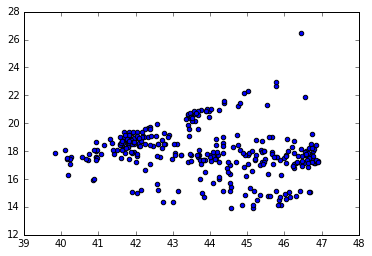

In [833]:
plt.scatter(pnls1[kmeans.labels_==opt_label],pnls2[kmeans.labels_==opt_label])
show()

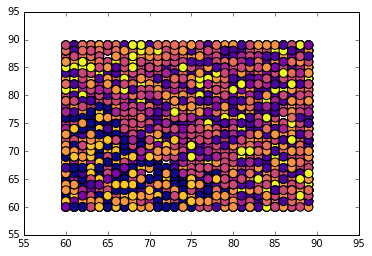

In [834]:
plt.scatter(np.array(params)[:,0],np.array(params)[:,1],c=kmeans.labels_,cmap='plasma',s=75)
show()

In [835]:
best_center = kmeans.cluster_centers_[opt_label]


In [836]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(3)
neigh.fit(np.array([pnls1,pnls2]).T,best_center)
dist,idx = neigh.kneighbors([best_center],15,return_distance=True)

In [837]:


# This is because we sometimes have larger and smaller lkbk reversed but sorted in the pnl calc, and we don't
# want to duplicate this.
unique_params = np.unique(map(sort,params[idx][0]),axis=0)
unique_params

array([[60, 86],
       [62, 87],
       [62, 89],
       [63, 85],
       [63, 89],
       [67, 88],
       [68, 88],
       [70, 82],
       [73, 78],
       [73, 80],
       [75, 86],
       [78, 89],
       [82, 87],
       [83, 87],
       [88, 89]])

41.2717760621 0.274066958254
40.0377398721 0.286311972728
40.2454201604 -0.414403336014
40.8718693348 0.400028774095
40.2258665237 0.154596603843
40.3333562204 -0.155921692663
40.2324093187 0.180345295688
42.1671080014 0.694027243532
42.4325144328 0.7269373928
42.0701093219 0.650270636899
41.801476255 -0.129587475353
41.8378071851 0.355605363829
41.9419897318 0.161566037089
41.8550332101 0.309532111965
41.2563170167 0.204582209863


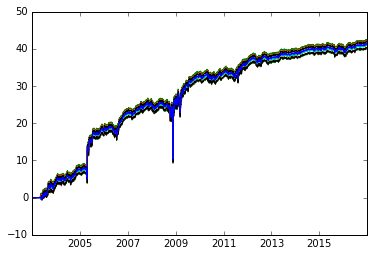

In [840]:
#calc_pnl(calc_signals(tickers,p,unique_params[idx][0][2][0],unique_params[idx][0][2][1]),p)
for par in unique_params:
    print (calc_pnl(calc_signals(tickers,p,par[0],par[1]),p))[-1],
    print (calc_sharpe(calc_signals(tickers,p,par[0],par[1]),p))
    plot((calc_pnl(calc_signals(tickers,p,par[0],par[1]),p)))
show()